# Plota dados da Janis da boia WAVESCAN do SIODOC
- Henrique P. P. Pereira
- Hanna Luizete
- Carlos E Parente

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pl
import numpy as np
import scipy.io
from datetime import datetime
import waveproc
matplotlib.reload(waveproc)
% matplotlib inline

In [2]:
#carrega dados processados - Janis

pathnamep = os.environ['HOME'] + '/Dropbox/database/historical/buoys/siodoc/arraial/proc/'

dateparse = lambda x: pd.datetime.strptime(x, '%d %m %Y %H %M %S')

janis = pd.read_table(pathnamep + 'janis_data.dat', sep='\s+', parse_dates=[[0,1,2,3,4,5]], header=None, date_parser=dateparse, index_col=['0_1_2_3_4_5'])

dd = janis.ix[:,[7,27,28,29,30,38,39,40,57,59,66,67,67]]

dd.columns = ['ate','hm0','hm0a','hm0b','hmax','mdir','mdira','mdirb','tp','wt','wd','ws','wg']

dd = dd['2014-10']

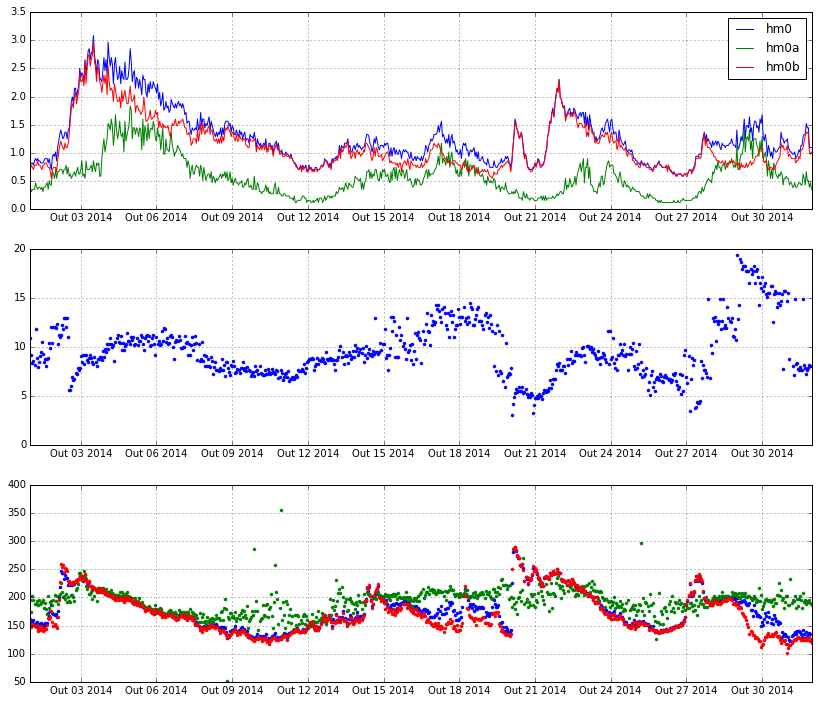

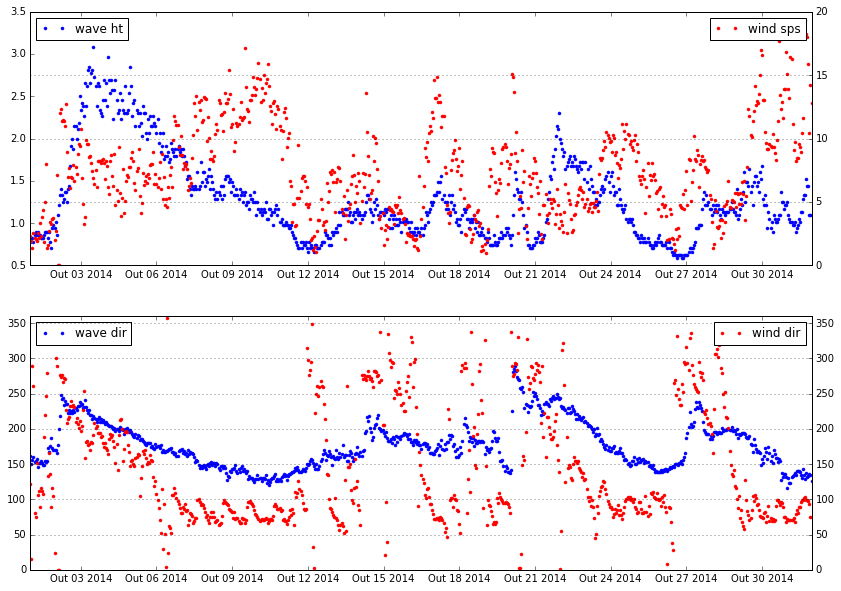

In [24]:
#onda

pl.close('all')

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0, label='hm0')
pl.plot(dd.index, dd.hm0a, label='hm0a')
pl.plot(dd.index, dd.hm0b, label='hm0b')
pl.grid(), pl.legend()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd.index, dd.mdira,'.')
pl.plot(dd.index, dd.mdirb,'.')
pl.grid()

#onda/vento

pl.figure(figsize=(14,10))
pl.subplot(211)
pl.plot(dd.index, dd.hm0,'b.', label='wave ht')
pl.legend(loc=2), pl.twinx(), pl.grid()
pl.plot(dd.index, dd.ws,'r.', label='wind sps')
pl.legend(loc=1)
pl.subplot(212)
pl.plot(dd.index, dd.mdir,'b.', label='wave dir')
pl.legend(loc=2), pl.ylim(0,360)
pl.twinx(), pl.grid()
pl.plot(dd.index, dd.wd,'r.', label='wind dir')
pl.legend(loc=1), pl.ylim(0,360)
pl.savefig('ondavento.png')

#temperatura do ar e da agua

#pl.figure(figsize=(14,10))
#pl.plot(dd.index, dd.ate,'b.', label='air temp')
#pl.plot(dd.index, dd.wt,'r.', label='water temp')
#pl.grid()
#pl.legend()

#pl.close('all')
pl.show()

# Processamento dos dados brutos de ondas da boia do SIODOC utilizando a classe waveproc
- Henrique P. P. Pereira

In [4]:
#carrega dados brutos de ondas

pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/siodoc/arraial/raw/'

#carrega arquivos .mat
hvmat = scipy.io.loadmat(pathname + 'heave.mat')
ptmat = scipy.io.loadmat(pathname + 'pitch.mat')
rlmat = scipy.io.loadmat(pathname + 'roll.mat')
cpmat = scipy.io.loadmat(pathname + 'compass.mat')

#retira as datas
hv1 = hvmat['heave'][:,6:]
pt1 = ptmat['pitch'][:,6:]
rl1 = rlmat['roll'][:,6:]
cp1 = cpmat['compass'][:,6:]

#data de todos os arquivos com datetime
data_all = hvmat['heave'][:,[0,1,2,3,4,5]]
datat_all = [datetime(int(data_all[i,0]),int(data_all[i,1]),int(data_all[i,2]),int(data_all[i,3])) for i in range(len(data_all))]
datat1 = np.array(datat_all) 

#create dataframe - pandas
hv = pd.DataFrame(hv1, index=datat1)['2014-10']
pt = pd.DataFrame(pt1, index=datat1)['2014-10']
rl = pd.DataFrame(rl1, index=datat1)['2014-10']
cp = pd.DataFrame(cp1, index=datat1)['2014-10']

In [5]:
#correcao do compass (NDBC 96, pg.14) - faz a correcao de pitch e roll em slpEW e slpNS

# valores do compass em radianos
cp_rad = cp * (np.pi/180)

#?? teste
cp_rad = np.arctan(np.sin(cp_rad) / np.cos(cp_rad))

#pitch
pitch_EW = ( (np.sin(cp_rad) * np.sin(pt)) / np.cos(pt) ) -  ( (np.cos(cp_rad) * np.sin(rl)) / (np.cos(pt) * np.cos(rl)) )

#roll
roll_NS = ( (np.cos(cp_rad) * np.sin(pt)) / np.cos(pt) ) +  ( (np.sin(cp_rad) * np.sin(rl)) / (np.cos(pt) * np.cos(rl)) )

pt1 = pitch_EW
rl1 = roll_NS

In [6]:
np.savetxt('heave.txt', hv.T.values, fmt='%.2f')
np.savetxt('pitch.txt', pt.T.values, fmt='%.2f')
np.savetxt('roll.txt', rl.T.values, fmt='%.2f')
np.savetxt('pitch_corr.txt', pt1.T.values, fmt='%.2f')
np.savetxt('roll_corr.txt', rl1.T.values, fmt='%.2f')

In [3]:
np.savetxt('wind.txt', dd['2014-10'][['ws', 'wd']].values, fmt='%.2f')
np.savetxt('siodoc.txt', dd['2014-10'][['hm0','hm0a','hm0b','hmax','mdir','mdira','mdirb','tp']].values, fmt='%.2f')

In [8]:
#processamento

w = waveproc.WaveProc(pathname)

w.h = 60
w.fs = 1.0
w.dt = 1 / w.fs
w.nfft = 128

dd1 = []
for i in range(len(hv)):
    
    print (hv.index[i])
    
    #w.date = datat1[i]
    w.date = hv.index[i]
    w.n1 = hv.ix[i]
    w.n2 = pt.ix[i]
    w.n3 = rl.ix[i]
    
    w.timedomain()
    w.freqdomain()
    
    pl.figure()
    pl.plot(w.sn1[:,1])
    pl.twinx()
    pl.plot(w.dire1,'r')
    pl.savefig('fig/siodoc/espe' + str(i))
    pl.close('all')
    
    dd1.append({'date'   : w.date,
               'hs'     : w.hs,
               'h10'    : w.h10,
               'hmax'   : w.hmax,
               'tmed'   : w.tmed,
               'thmax'  : w.thmax,
               'hm0'    : w.hm0,
               'tp'     : w.tp,
               'dp'     : w.dp,
               'tzamax' : w.tzamax})
    
dd1 = pd.DataFrame(dd1)
dd1 = dd1.set_index('date')

2014-10-01 00:00:00
2014-10-01 01:00:00
2014-10-01 02:00:00
2014-10-01 03:00:00
2014-10-01 04:00:00
2014-10-01 05:00:00
2014-10-01 06:00:00
2014-10-01 07:00:00
2014-10-01 08:00:00
2014-10-01 09:00:00
2014-10-01 10:00:00
2014-10-01 11:00:00
2014-10-01 12:00:00
2014-10-01 13:00:00
2014-10-01 14:00:00
2014-10-01 15:00:00
2014-10-01 16:00:00
2014-10-01 17:00:00
2014-10-01 18:00:00
2014-10-01 19:00:00
2014-10-01 20:00:00
2014-10-01 21:00:00
2014-10-01 22:00:00
2014-10-01 23:00:00
2014-10-02 00:00:00
2014-10-02 01:00:00
2014-10-02 02:00:00
2014-10-02 03:00:00
2014-10-02 04:00:00
2014-10-02 05:00:00
2014-10-02 06:00:00
2014-10-02 07:00:00
2014-10-02 08:00:00
2014-10-02 09:00:00
2014-10-02 10:00:00
2014-10-02 11:00:00
2014-10-02 12:00:00
2014-10-02 13:00:00
2014-10-02 14:00:00
2014-10-02 15:00:00
2014-10-02 16:00:00
2014-10-02 17:00:00
2014-10-02 18:00:00
2014-10-02 19:00:00
2014-10-02 20:00:00
2014-10-02 21:00:00
2014-10-02 22:00:00
2014-10-02 23:00:00
2014-10-03 00:00:00
2014-10-03 01:00:00


# Plota comparacao do bruto e reprocessado SIODOC

In [11]:
#plotagem bruto e reprocessado

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0, label='proc')
pl.plot(dd1.index, dd1.hm0, label='reproc')
pl.grid(), pl.legend()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.plot(dd1.index, dd1.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd1.index, dd1.dp,'.')
pl.plot(dd.index, dd.wd,'.')
pl.grid()

pl.show()

#pl.savefig('comparacao_proc_reproc.png')

# Processamento dos dados de Ilha Rasa - Sensor GX3


In [35]:
pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/lts/ilharasa_hanna/'

aew = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclEW.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

ans = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclNS.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

av = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclV.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

#remove uma coluna que nao faz parte da serie temporal
aew = aew.drop(aew.columns[0], axis=1)
ans = ans.drop(ans.columns[0], axis=1)
av = av.drop(av.columns[0], axis=1)

In [37]:
#processamento

w = waveproc.WaveProc(pathname)

w.h = 60
w.fs = 1.0
w.dt = 1 / w.fs
w.nfft = 128

dd2 = []
for i in range(len(av)):
    
#     print (av.index[i])
    
    w.date = av.index[i]
    w.n1 = av.ix[i]
    w.n2 = ans.ix[i]
    w.n3 = aew.ix[i]
    
#     w.timedomain()
    w.freqdomain()
    
    dd2.append({'date'   : w.date,
#                'hs'     : w.hs,
#                'h10'    : w.h10,
#                'hmax'   : w.hmax,
#                'tmed'   : w.tmed,
#                'thmax'  : w.thmax,
               'hm0'    : w.hm0,
               'tp'     : w.tp,
               'dp'     : w.dp,
#                'tzamax' : w.tzamax
              })
    
dd2 = pd.DataFrame(dd2)
dd2 = dd2.set_index('date')

In [11]:
#plotagem bruto e reprocessado

%matplotlib qt

inter1 = '2014-10-01'
inter2 = '2014-10-31'


pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd[inter1:inter2].index, dd[inter1:inter2].hm0, label='proc')
pl.plot(dd1[inter1:inter2].index, dd1[inter1:inter2].hm0, label='reproc')
pl.plot(dd2[inter1:inter2].index, dd2[inter1:inter2].hm0, label='ilharasa')
#l.plot(dd[inter1:inter2].index, dd[inter1:inter2].ws, label='wind')

pl.grid(), pl.legend()
pl.subplot(312)
pl.plot(dd[inter1:inter2].index, dd[inter1:inter2].tp,'.')
pl.plot(dd1[inter1:inter2].index, dd1[inter1:inter2].tp,'.')
pl.plot(dd2[inter1:inter2].index, dd2[inter1:inter2].tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
#pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd[inter1:inter2].index, dd[inter1:inter2].mdir,'.')
pl.plot(dd1[inter1:inter2].index, dd1[inter1:inter2].dp,'.')
pl.plot(dd2[inter1:inter2].index, dd2[inter1:inter2].dp,'.')
pl.plot(dd[inter1:inter2].index, dd[inter1:inter2].wd,'.')
pl.grid()



NameError: name 'dd1' is not defined

In [22]:
# plota os parametros de hs, tp e dp processado pela ambidados

pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/siodoc/arraial/'

#03/10/2014 15h -- #31/12/2014 19h

hs = np.loadtxt(pathname + 'Hs.txt')
tp = np.loadtxt(pathname + 'Tp.txt')
dp = np.loadtxt(pathname + 'Dp.txt')
data = np.loadtxt(pathname + 'data.txt')


#pd.date_range('2014-10-03 15h', '2014-12-31 19h', freq='H').shape
#hs.shape


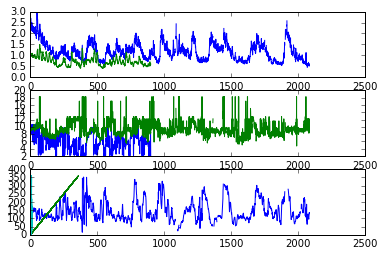

In [23]:

%matplotlib inline

pl.figure()
pl.subplot(311)
pl.plot(hs)
pl.plot(dd2.hm0.values)
pl.subplot(312)
pl.plot(dd2.tp.values)
pl.plot(tp)
pl.subplot(313)
pl.plot(dp)
pl.plot(dd2, dd2.dp.values)

pl.show()

In [129]:
#carrega dados de vento do cfsr

pathnamewind = os.environ['HOME'] + '/Dropbox/database/'

time = np.loadtxt(pathnamewind + 'time_IlhaRasa_201410.txt')
u = np.loadtxt(pathnamewind + 'uCFSR_IlhaRasa_201410.txt')
v = np.loadtxt(pathnamewind + 'vCFSR_IlhaRasa_201410.txt')

#retira dias repetidos
[time1,ia] = np.unique(time, return_index=True);
time1 = time1[:-1]
u = u[ia[:-1]];
v = v[ia[:-1]];

ws1 = np.sqrt(u**2 + v**2);
wd1 = np.arctan2(v,u) * 180 / np.pi; #vento de onde vem
wd1 = 270 - wd1; #de onde vai para onde vem
wd1[pl.find(wd1<0)] = wd1[pl.find(wd1<0)] + 360;
wd1[pl.find(wd1>360)] = wd1[pl.find(wd1>360)] - 360;



###carrega vento ilha rasa
pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/lts/ilharasa_hanna/'

#carrega arquivos .mat
wind = scipy.io.loadmat(pathname + 'wind.mat')

wind
#wind.shape
#retira as datas
wnd = wind['wind'][:]
#wnd = wind['d'][:]
wnd
#wnd
date = [datetime(int(wnd[i,0]), int(wnd[i,1]), int(wnd[i, 2]), int(wnd[i, 3])) for i in range(len(wnd))]

wind = pd.DataFrame(wnd[:,[6,7]], index=date)['2014-10']


dd = dd['2014-10']

pl.figure()
pl.subplot(211)
#pl.plot(ws1,'.')
pl.plot(dd.ws.values, '.')
pl.plot(wind.ix[:,1].values)
pl.subplot(212)
#pl.plot(wd1,'.')
#pl.plot(dd.wd.values-23, '.')
pl.plot(dd2.dp.values,'.')
pl.plot(wind.ix[:,0].values,'.')


pl.show()